<a href="https://colab.research.google.com/github/Yashyupr/Analytics-Using-Python/blob/master/Enhancing_Resume_Categorization_with_Neural_Network_and_NLP_Text_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
col_pal = sns.color_palette()
import random
import re
from pdfminer.high_level import extract_pages, extract_text
import statistics
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from collections import defaultdict
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data_path = '/content/drive/MyDrive/CV for Dissertation/Dataset'

data = {'file': [], 'type': []}

# Iterate through the directory and its subdirectories
for root, dirs, files in os.walk(data_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_type = os.path.basename(root)
        data['file'].append(file_path)
        data['type'].append(file_type)

# Create a DataFrame from the data dictionary
data_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(data_df.head())

                                                file type
0  /content/drive/MyDrive/CV for Dissertation/Dat...   IT
1  /content/drive/MyDrive/CV for Dissertation/Dat...   IT
2  /content/drive/MyDrive/CV for Dissertation/Dat...   IT
3  /content/drive/MyDrive/CV for Dissertation/Dat...   IT
4  /content/drive/MyDrive/CV for Dissertation/Dat...   IT


#Data Distribution Visualization

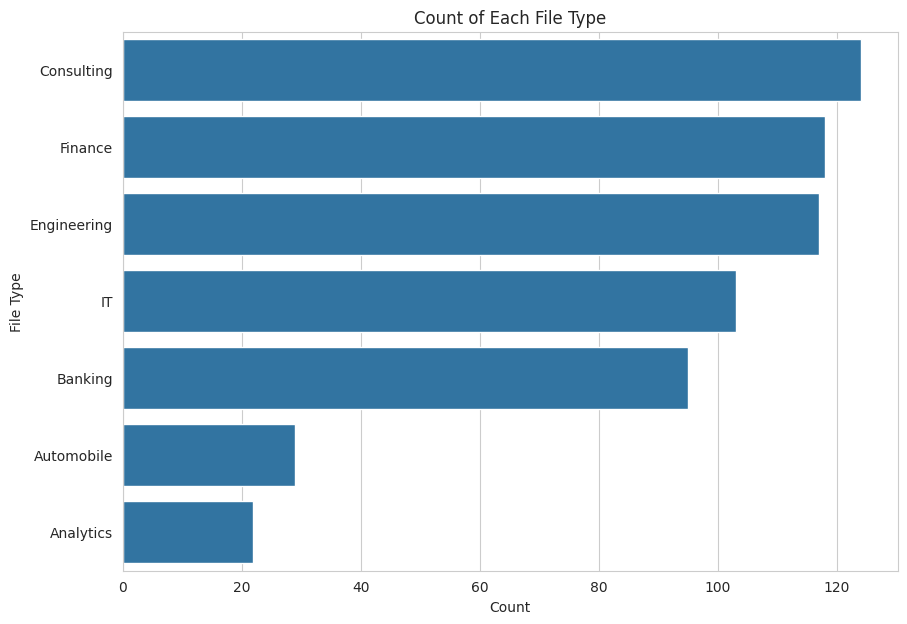

In [ ]:
occurrence = data_df['type'].value_counts()

# Sort the data in ascending order
occurrence_sorted = occurrence.sort_values(ascending=False)

# Set the style of seaborn
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 7))
sns.barplot(x = occurrence_sorted.values, y = occurrence_sorted.index)
plt.xlabel('Count')
plt.ylabel('File Type')
plt.title('Count of Each File Type')
plt.show()

#Extracting Text from PDF

In [ ]:
!pip install pdfminer.six

In [ ]:
# Function to extract text from a single PDF file
def extract_text_from_pdf(file_path):
    try:
        text = extract_text(file_path)
        if isinstance(text, str):
            return text.replace('\n', ' ')
        else:
            return ''  # Return empty string if text is not a string
    except Exception as e:
        print(f"Error extracting text from {file_path}: {e}")
        return ''

In [ ]:
# Initialize lists to store extracted text
texts_cv = []
empty_cv = []

In [ ]:
# Iterate through each file in the DataFrame
for file_path in data_df['file']:
    text = extract_text_from_pdf(file_path)
    if text:
        texts_cv.append(text)
    else:
        empty_cv.append(file_path)

In [ ]:
# Convert the list of texts to strings
texts_cv_str = [str(text) for text in texts_cv]

# Create a DataFrame to store the texts
text_data_df = pd.DataFrame({'text': texts_cv_str})

# Shuffle the DataFrame
shuffled_text_data_df = text_data_df.sample(frac=1).reset_index(drop=True)

# Add the file paths to the DataFrame
shuffled_text_data_df['file'] = data_df['file']

# Access the shuffled texts and file paths
shuffled_texts_cv = shuffled_text_data_df['text']
shuffled_file_paths = shuffled_text_data_df['file']

In [ ]:
print(shuffled_texts_cv.head())

0    FINANCE OFFICER Summary Competent and reliable...
1    CONSULTANT Experience Consultant  January 2012...
2    LEASING CONSULTANT Summary To attain a positio...
3    CONSULTANT Executive Profile Over 5 years expe...
4    ENGINEERING TECHNICIAN Summary Work as enginee...
Name: text, dtype: object


In [ ]:
shuffled_texts_cv[0]

"FINANCE OFFICER Summary Competent and reliable professional, committed to excellence with proven team leading and team building skills, who sees challenges as an opportunity to grow and develop. Ability to lead a team of people from diverse backgrounds, by communicating clear goals and objectives, and understanding and resolving the needs of the team to ensure that targets are met. Responsible, analytical, results oriented, effective, efficient and flexible work attitude which aims to achieve and surpass set goals. Highly confidential, honest, pro-active individual who operates with integrity in all aspects of life, possessing expertise in Accounting, Supervisory Management and Training skills. Highlights  ACCPAC accounting skills Analytical reasoning Budget analysis Account reconciliations  Accomplishments  Liaised with the BPI Team in investigating and understanding the nature of most of the errors on the Savings & IP Schedules thus enabling me to clear most of the items  Successful

In [ ]:
len(empty_cv)

0

In [ ]:
data['text'] = shuffled_texts_cv

for key in empty_cv:
    data.pop(key, None)

#Exploratory Data Analysis

In [ ]:
cv_length=[len(i) for i in shuffled_texts_cv]

Text(0.5, 1.0, 'CV Length')

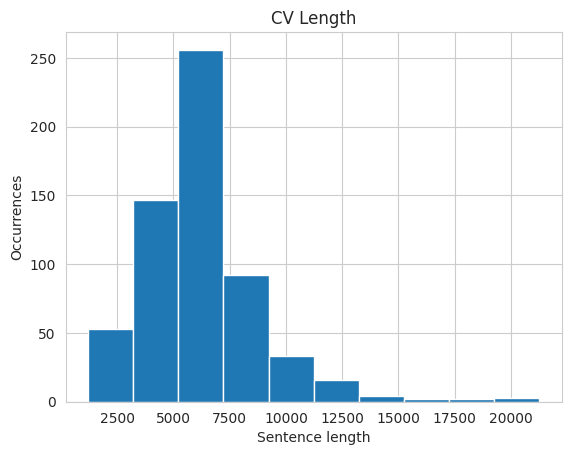

In [ ]:
plt.hist(cv_length)
plt.xlabel('Sentence length')
plt.ylabel('Occurrences')
plt.title('CV Length')

In [ ]:
# Calculate basic statistics
mean = statistics.mean(cv_length)  # Mean of CV Length
min = min(cv_length)  # Minimum Length
max = max(cv_length)  # Maximum Length
std = statistics.stdev(cv_length)  # Standard deviation
var = statistics.variance(cv_length)  # Variance

# Print the results
print("Mean CV length:", mean)
print("Minimum CV length:", min)
print("Maximum CV length:", max)
print("Standard deviation of CV length:", std)
print("Variance of CV length:", var)

# Calculate the number of CVs
num_cvs = len(cv_length)
print("Number of CVs:", num_cvs)

Mean CV length: 6292.743421052632
Minimum CV length: 1208
Maximum CV length: 21256
Standard deviation of CV length: 2553.107173071459
Variance of CV length: 6518356.237188936
Number of CVs: 608


In [ ]:
vocab_size= int(mean + (3 * std)) #Removing outlier
vocab_size

13952

#Data Splitting

In [ ]:
print("Total number of CVs in the original data:", len(data_df))

Total number of CVs in the original data: 608


In [ ]:
# Identify unique labels
unique_labels = data_df['type'].unique()

# Initialize dictionaries to store indices of samples for each label
train_indices = defaultdict(list)
test_indices = defaultdict(list)

In [ ]:
# Randomly split samples for each label into train and test sets
for label in unique_labels:
    label_indices = np.where(data_df['type'] == label)[0]
    np.random.shuffle(label_indices)
    split_index = int(0.8 * len(label_indices))
    train_indices[label] = label_indices[:split_index]
    test_indices[label] = label_indices[split_index:]

In [ ]:
# Combine indices for all labels into train and test sets
train_indices_all = np.concatenate(list(train_indices.values()))
test_indices_all = np.concatenate(list(test_indices.values()))

# Create train and test sets using the indices
X_train = text_data_df['text'][train_indices_all]
Y_train = data_df['type'][train_indices_all]
X_test = text_data_df['text'][test_indices_all]
Y_test = data_df['type'][test_indices_all]

In [ ]:
text_data_df = pd.DataFrame({'text': texts_cv_str, 'file': shuffled_file_paths})

print(text_data_df.head())

# Merge text_data_df with data_df if necessary
data_df = pd.merge(data_df, text_data_df, on='file', how='inner')

                                                text  \
0  PROJECT MANAGER AND TECHNICAL IMPLEMENTATION C...   
1  INFORMATION TECHNOLOGY SPECIALIST (WEB), GS-11...   
2  INFORMATION TECHNOLOGY SPECIALIST(DISCOUNTPCFI...   
3  INFORMATION TECHNOLOGY INTERN Professional Pro...   
4  INFORMATION TECHNOLOGY (IT) SPECIALIST Experie...   

                                                file  
0  /content/drive/MyDrive/CV for Dissertation/Dat...  
1  /content/drive/MyDrive/CV for Dissertation/Dat...  
2  /content/drive/MyDrive/CV for Dissertation/Dat...  
3  /content/drive/MyDrive/CV for Dissertation/Dat...  
4  /content/drive/MyDrive/CV for Dissertation/Dat...  


In [ ]:
# Print the sizes of train and test sets
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

Size of training set: 484
Size of testing set: 124


In [ ]:
# Get unique labels for train and test data
unique_labels_train = data_df.loc[train_indices_all, 'type'].unique()
unique_labels_test = data_df.loc[test_indices_all, 'type'].unique()

# Print unique labels for train and test data
print("Unique labels in train data:", unique_labels_train)
print("Unique labels in test data:", unique_labels_test)

Unique labels in train data: ['IT' 'Banking' 'Consulting' 'Analytics' 'Automobile' 'Engineering'
 'Finance']
Unique labels in test data: ['IT' 'Banking' 'Consulting' 'Analytics' 'Automobile' 'Engineering'
 'Finance']


In [ ]:
print(data_df.columns)

Index(['file', 'type', 'text'], dtype='object')


In [ ]:
# Display the first few rows of your DataFrame
print(data_df.head())

                                                file type  \
0  /content/drive/MyDrive/CV for Dissertation/Dat...   IT   
1  /content/drive/MyDrive/CV for Dissertation/Dat...   IT   
2  /content/drive/MyDrive/CV for Dissertation/Dat...   IT   
3  /content/drive/MyDrive/CV for Dissertation/Dat...   IT   
4  /content/drive/MyDrive/CV for Dissertation/Dat...   IT   

                                                text  
0  PROJECT MANAGER AND TECHNICAL IMPLEMENTATION C...  
1  INFORMATION TECHNOLOGY SPECIALIST (WEB), GS-11...  
2  INFORMATION TECHNOLOGY SPECIALIST(DISCOUNTPCFI...  
3  INFORMATION TECHNOLOGY INTERN Professional Pro...  
4  INFORMATION TECHNOLOGY (IT) SPECIALIST Experie...  


#Convolutional Neural Network (CNN) for Text Classification

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Define the desired minimum and maximum sequence lengths
min_len = 1208  # Minimum CV length
max_len = 21256  # Maximum CV length

# Padding sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels in the training set
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Transform labels in the testing set
Y_test_encoded = label_encoder.transform(Y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Define the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Define the embedding dimension
embedding_dim = 200

# Define the CNN model
model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Add a 1D convolutional layer
filters = 128
kernel_size = 5
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))

# Add global max pooling layer
model.add(GlobalMaxPooling1D())

# Add a Dense layer
hidden_units = 64
model.add(Dense(hidden_units, activation='relu'))

# Add a dropout layer for regularization
dropout_rate = 0.2
model.add(Dropout(rate=dropout_rate))

# Output layer
num_classes = len(np.unique(Y_train))  # Number of unique classes
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21256, 200)        3793800   
                                                                 
 conv1d (Conv1D)             (None, 21252, 128)        128128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                        

In [ ]:
# Train the model
history = model.fit(X_train_pad, Y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 12s 448ms/step - loss: 1.8884 - accuracy: 0.1783 - val_loss: 2.4067 - val_accuracy: 0.0206
Epoch 2/10
13/13 [==============================] - 4s 290ms/step - loss: 1.6352 - accuracy: 0.4134 - val_loss: 3.0563 - val_accuracy: 0.0206
Epoch 3/10
13/13 [==============================] - 4s 299ms/step - loss: 1.4510 - accuracy: 0.6072 - val_loss: 3.6346 - val_accuracy: 0.0206
Epoch 4/10
13/13 [==============================] - 5s 378ms/step - loss: 1.2954 - accuracy: 0.6796 - val_loss: 3.9182 - val_accuracy: 0.0206
Epoch 5/10
13/13 [==============================] - 4s 325ms/step - loss: 1.0577 - accuracy: 0.7881 - val_loss: 4.0514 - val_accuracy: 0.0309
Epoch 6/10
13/13 [==============================] - 4s 301ms/step - loss: 0.7536 - accuracy: 0.8811 - val_loss: 4.2681 - val_accuracy: 0.0309
Epoch 7/10
13/13 [==============================] - 4s 331ms/step - loss: 0.5028 - accuracy: 0.8941 - val_loss: 4.6805 - val_accuracy: 0.0206
Epoch

In [ ]:
# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test_pad, Y_test_encoded)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


4/4 [==============================] - 1s 394ms/step - loss: 1.6886 - accuracy: 0.6452
Test Loss: 1.6885665655136108
Test Accuracy: 0.6451612710952759


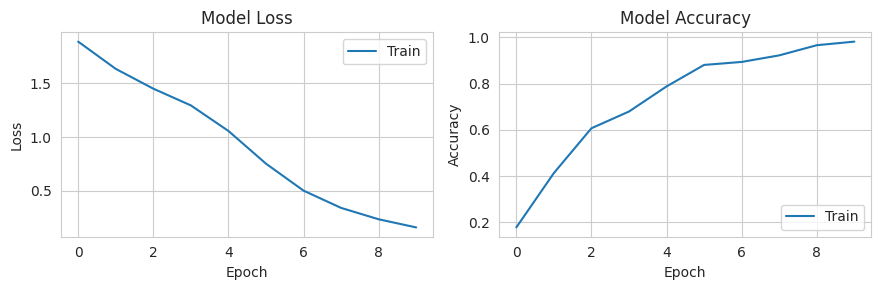

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot training loss values
axes[0].plot(history.history['loss'])
axes[0].set_title('Model Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train'], loc='upper right')

# Plot training accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train'], loc='lower right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Predictions on the test set
predictions = model.predict(X_test_pad)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert encoded labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to compare actual vs. predicted labels
results_df = pd.DataFrame({'Actual_Labels': Y_test, 'Predicted_Labels': predicted_labels})

print("Actual vs. Predicted after CNN:")
print(results_df.sample(10))

4/4 [==============================] - 0s 86ms/step
Actual vs. Predicted after CNN:
    Actual_Labels Predicted_Labels
271    Consulting       Consulting
137       Banking          Banking
300    Consulting       Consulting
531       Finance       Consulting
385   Engineering      Engineering
3              IT               IT
527       Finance       Consulting
546       Finance          Banking
478   Engineering      Engineering
486   Engineering      Engineering


#Text Augmentation

#Synonym Replacement

In [ ]:
# Function to perform synonym replacement
def synonym_replacement(sentence, n=1):
    words = nltk.word_tokenize(sentence)
    new_sentence = sentence
    for _ in range(n):
        for i in range(len(words)):
            syns = wordnet.synsets(words[i])
            if syns:
                synonyms = [lemma.name().replace('_', ' ') for lemma in syns[0].lemmas()]
                if synonyms:
                    new_word = random.choice(synonyms)  # Choose a random synonym
                    words[i] = new_word
                    new_sentence = ' '.join(words)
                    break
    return new_sentence

In [ ]:
# Define a function to perform synonym replacement on a single text sample
def augment_text(text):
    return synonym_replacement(text)

# Group text samples by label
grouped_data = defaultdict(list)
for label, text in zip(data_df['type'], data_df['text']):
    grouped_data[label].append(text)

# Apply synonym replacement to each group of text samples
augmented_texts = []
for label, texts in grouped_data.items():
    augmented_group = [augment_text(text) for text in texts]
    augmented_texts.extend(augmented_group)

# Add the augmented text back to the DataFrame
data_df['augmented_text'] = augmented_texts

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
filters = 128
kernel_size = 5
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))

model.add(GlobalMaxPooling1D())

hidden_units = 64
model.add(Dense(hidden_units, activation='relu'))

dropout_rate = 0.2
model.add(Dropout(rate=dropout_rate))

num_classes = len(np.unique(Y_train))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21256, 200)        3793800   
                                                                 
 conv1d_1 (Conv1D)           (None, 21252, 128)        128128    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                      

In [ ]:
# Train the model
history = model.fit(X_train_pad, Y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 5s 311ms/step - loss: 1.8960 - accuracy: 0.1886 - val_loss: 2.4216 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 4s 297ms/step - loss: 1.7071 - accuracy: 0.3049 - val_loss: 3.1048 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 5s 398ms/step - loss: 1.5288 - accuracy: 0.5013 - val_loss: 3.6726 - val_accuracy: 0.0206
Epoch 4/10
13/13 [==============================] - 4s 313ms/step - loss: 1.3673 - accuracy: 0.5633 - val_loss: 4.0243 - val_accuracy: 0.0206
Epoch 5/10
13/13 [==============================] - 4s 313ms/step - loss: 1.1406 - accuracy: 0.6822 - val_loss: 4.4399 - val_accuracy: 0.0309
Epoch 6/10
13/13 [==============================] - 5s 388ms/step - loss: 0.8944 - accuracy: 0.7390 - val_loss: 4.9354 - val_accuracy: 0.0309
Epoch 7/10
13/13 [==============================] - 4s 300ms/step - loss: 0.6453 - accuracy: 0.8372 - val_loss: 5.4007 - val_accuracy: 0.030

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_pad, Y_test_encoded)

print("Synonym Replacement Loss:", test_loss)
print("Synonym Replacement Accuracy:", test_accuracy)

4/4 [==============================] - 0s 80ms/step - loss: 1.9019 - accuracy: 0.6129
Synonym Replacement Loss: 1.9019073247909546
Synonym Replacement Accuracy: 0.6129032373428345


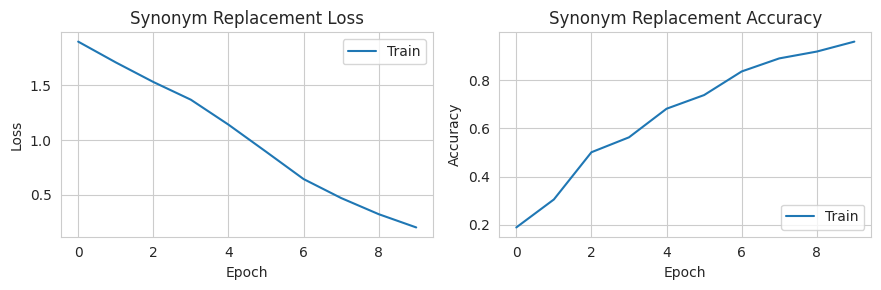

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot training loss values
axes[0].plot(history.history['loss'])
axes[0].set_title('Synonym Replacement Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train'], loc='upper right')

# Plot training accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].set_title('Synonym Replacement Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train'], loc='lower right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Predictions on the test set
predictions = model.predict(X_test_pad)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert encoded labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to compare actual vs. predicted labels
results_df = pd.DataFrame({'Actual_Labels': Y_test, 'Predicted_Labels': predicted_labels})

print("Actual vs. Predicted after Synonym Replacement:")
print(results_df.sample(10))

4/4 [==============================] - 0s 76ms/step
Actual vs. Predicted after Synonym Replacement:
    Actual_Labels Predicted_Labels
347    Automobile      Engineering
526       Finance          Banking
106       Banking          Banking
495       Finance          Banking
13             IT       Consulting
448   Engineering      Engineering
485   Engineering      Engineering
564       Finance      Engineering
472   Engineering      Engineering
480   Engineering      Engineering


#Random Insertion

In [ ]:
import random
from nltk.tokenize import word_tokenize

# Define the augmentation method
def augment_text_random_insertion(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Randomly select a position to insert a word
    insert_idx = random.randint(0, len(words))

    # Insert a random word at the selected position
    random_word = "randomword"
    words.insert(insert_idx, random_word)

    # Concatenate the words back into a single string
    augmented_text = " ".join(words)

    return augmented_text

# Group text samples by label
grouped_data = defaultdict(list)
for label, text in zip(data_df['type'], data_df['text']):
    grouped_data[label].append(text)

# Apply random insertion to each group of text samples
augmented_texts = []
for label, texts in grouped_data.items():
    augmented_group = [augment_text_random_insertion(text) for text in texts]
    augmented_texts.extend(augmented_group)

# Add the augmented text back to the DataFrame
data_df['augmented_text_random_insertion'] = augmented_texts

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
filters = 128
kernel_size = 5
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
hidden_units = 64
model.add(Dense(hidden_units, activation='relu'))
dropout_rate = 0.2
model.add(Dropout(rate=dropout_rate))
num_classes = len(np.unique(Y_train))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21256, 200)        3793800   
                                                                 
 conv1d_2 (Conv1D)           (None, 21252, 128)        128128    
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                      

In [ ]:
# Train the model
history = model.fit(X_train_pad, Y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 6s 372ms/step - loss: 1.8847 - accuracy: 0.1912 - val_loss: 2.4811 - val_accuracy: 0.0309
Epoch 2/10
13/13 [==============================] - 5s 341ms/step - loss: 1.6576 - accuracy: 0.4109 - val_loss: 3.1735 - val_accuracy: 0.0206
Epoch 3/10
13/13 [==============================] - 4s 320ms/step - loss: 1.4775 - accuracy: 0.6098 - val_loss: 3.7490 - val_accuracy: 0.0309
Epoch 4/10
13/13 [==============================] - 4s 314ms/step - loss: 1.3088 - accuracy: 0.6925 - val_loss: 3.9503 - val_accuracy: 0.0309
Epoch 5/10
13/13 [==============================] - 6s 507ms/step - loss: 1.0650 - accuracy: 0.8501 - val_loss: 4.1105 - val_accuracy: 0.0309
Epoch 6/10
13/13 [==============================] - 5s 386ms/step - loss: 0.7779 - accuracy: 0.8605 - val_loss: 4.2909 - val_accuracy: 0.0309
Epoch 7/10
13/13 [==============================] - 5s 372ms/step - loss: 0.5220 - accuracy: 0.8992 - val_loss: 4.5021 - val_accuracy: 0.0309
Epoch 

In [ ]:
# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test_pad, Y_test_encoded)

# Print the test loss and accuracy
print("Random Insertion Loss:", test_loss)
print("Random Insertion Accuracy:", test_accuracy)

4/4 [==============================] - 0s 76ms/step - loss: 1.8699 - accuracy: 0.5403
Random Insertion Loss: 1.8699427843093872
Random Insertion Accuracy: 0.5403226017951965


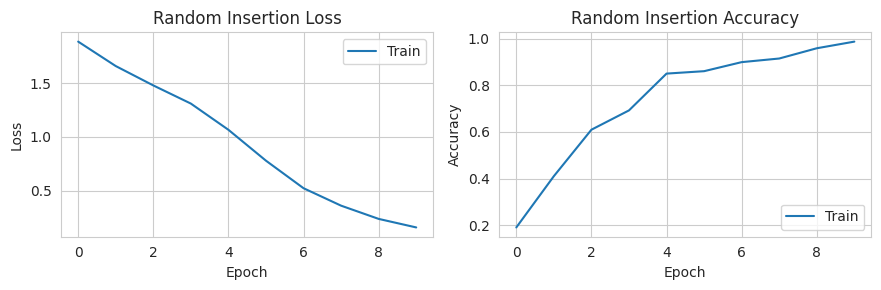

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot training loss values
axes[0].plot(history.history['loss'])
axes[0].set_title('Random Insertion Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train'], loc='upper right')

# Plot training accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].set_title('Random Insertion Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train'], loc='lower right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Predictions on the test set
predictions = model.predict(X_test_pad)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert encoded labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to compare actual vs. predicted labels
results_df = pd.DataFrame({'Actual_Labels': Y_test, 'Predicted_Labels': predicted_labels})

print("Actual vs. Predicted after Random Insertion:")
print(results_df.sample(10))

4/4 [==============================] - 0s 81ms/step
Actual vs. Predicted after Random Insertion:
    Actual_Labels Predicted_Labels
587       Finance       Consulting
392   Engineering      Engineering
564       Finance      Engineering
195       Banking          Banking
367    Automobile       Consulting
480   Engineering      Engineering
312    Consulting               IT
221    Consulting      Engineering
188       Banking          Banking
271    Consulting       Consulting


#Random Deletion

In [ ]:
import random
from nltk.tokenize import word_tokenize

# Define the augmentation method
def augment_text_random_deletion(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Randomly select words to delete
    num_words_to_delete = len(words) // 3  # Delete approximately 1/3 of words
    delete_indices = random.sample(range(len(words)), num_words_to_delete)

    # Delete the selected words
    augmented_words = [word for idx, word in enumerate(words) if idx not in delete_indices]

    # Concatenate the remaining words back into a single string
    augmented_text = " ".join(augmented_words)

    return augmented_text

# Group text samples by label
grouped_data = defaultdict(list)
for label, text in zip(data_df['type'], data_df['text']):
    grouped_data[label].append(text)

# Apply random deletion to each group of text samples
augmented_texts = []
for label, texts in grouped_data.items():
    augmented_group = [augment_text_random_deletion(text) for text in texts]
    augmented_texts.extend(augmented_group)

# Add the augmented text back to the DataFrame
data_df['augmented_text_random_deletion'] = augmented_texts

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
filters = 128
kernel_size = 5
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
hidden_units = 64
model.add(Dense(hidden_units, activation='relu'))
dropout_rate = 0.2
model.add(Dropout(rate=dropout_rate))
num_classes = len(np.unique(Y_train))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 21256, 200)        3793800   
                                                                 
 conv1d_3 (Conv1D)           (None, 21252, 128)        128128    
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 7)                 455       
                                                      

In [ ]:
# Train the model
history = model.fit(X_train_pad, Y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 6s 370ms/step - loss: 1.8737 - accuracy: 0.2455 - val_loss: 2.4550 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - 5s 390ms/step - loss: 1.6654 - accuracy: 0.3049 - val_loss: 3.0320 - val_accuracy: 0.0000e+00
Epoch 3/10
13/13 [==============================] - 9s 718ms/step - loss: 1.5191 - accuracy: 0.3566 - val_loss: 3.6215 - val_accuracy: 0.0103
Epoch 4/10
13/13 [==============================] - 8s 587ms/step - loss: 1.3713 - accuracy: 0.5685 - val_loss: 3.9937 - val_accuracy: 0.0309
Epoch 5/10
13/13 [==============================] - 5s 367ms/step - loss: 1.1673 - accuracy: 0.7700 - val_loss: 4.1175 - val_accuracy: 0.0309
Epoch 6/10
13/13 [==============================] - 5s 392ms/step - loss: 0.9437 - accuracy: 0.8605 - val_loss: 4.4352 - val_accuracy: 0.0309
Epoch 7/10
13/13 [==============================] - 5s 367ms/step - loss: 0.7085 - accuracy: 0.8734 - val_loss: 4.6170 - val_accuracy: 0.030

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_pad, Y_test_encoded)

print("Random Deletion Loss:", test_loss)
print("Random Deletion Accuracy:", test_accuracy)

4/4 [==============================] - 0s 86ms/step - loss: 1.7840 - accuracy: 0.5726
Random Deletion Loss: 1.7840397357940674
Random Deletion Accuracy: 0.5725806355476379


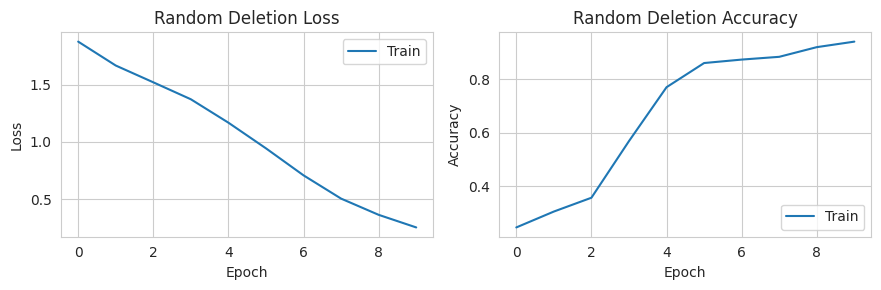

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot training loss values
axes[0].plot(history.history['loss'])
axes[0].set_title('Random Deletion Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train'], loc='upper right')

# Plot training accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].set_title('Random Deletion Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train'], loc='lower right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Predictions on the test set
predictions = model.predict(X_test_pad)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert encoded labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to compare actual vs. predicted labels
results_df = pd.DataFrame({'Actual_Labels': Y_test, 'Predicted_Labels': predicted_labels})

print("Actual vs. Predicted after Random Deletion:")
print(results_df.sample(10))

4/4 [==============================] - 0s 80ms/step
Actual vs. Predicted after Random Deletion:
    Actual_Labels Predicted_Labels
311    Consulting       Consulting
4              IT      Engineering
368    Automobile          Banking
81             IT               IT
188       Banking          Banking
531       Finance          Banking
3              IT               IT
84             IT      Engineering
108       Banking      Engineering
367    Automobile          Banking


#Random Swap

In [ ]:
import random
from nltk.tokenize import word_tokenize

# Define the augmentation method
def augment_text_random_swap(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Perform random word swaps
    num_swaps = len(words) // 4  # Perform approximately one-fourth of the total number of word swaps
    for _ in range(num_swaps):
        # Randomly select two indices to swap
        idx1, idx2 = random.sample(range(len(words)), 2)

        # Perform the swap
        words[idx1], words[idx2] = words[idx2], words[idx1]

    # Concatenate the words back into a single string
    augmented_text = " ".join(words)

    return augmented_text

# Group text samples by label
grouped_data = defaultdict(list)
for label, text in zip(data_df['type'], data_df['text']):
    grouped_data[label].append(text)

# Apply random swap to each group of text samples
augmented_texts = []
for label, texts in grouped_data.items():
    augmented_group = [augment_text_random_swap(text) for text in texts]
    augmented_texts.extend(augmented_group)

# Add the augmented text back to the DataFrame
data_df['augmented_text_random_swap'] = augmented_texts

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
filters = 128
kernel_size = 5
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
hidden_units = 64
model.add(Dense(hidden_units, activation='relu'))
dropout_rate = 0.2
model.add(Dropout(rate=dropout_rate))
num_classes = len(np.unique(Y_train))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 21256, 200)        3793800   
                                                                 
 conv1d_4 (Conv1D)           (None, 21252, 128)        128128    
                                                                 
 global_max_pooling1d_4 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                      

In [ ]:
# Train the model
history = model.fit(X_train_pad, Y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 6s 365ms/step - loss: 1.9031 - accuracy: 0.2171 - val_loss: 2.4435 - val_accuracy: 0.0206
Epoch 2/10
13/13 [==============================] - 7s 556ms/step - loss: 1.6486 - accuracy: 0.5375 - val_loss: 3.0700 - val_accuracy: 0.0309
Epoch 3/10
13/13 [==============================] - 5s 407ms/step - loss: 1.4402 - accuracy: 0.5762 - val_loss: 3.8005 - val_accuracy: 0.0309
Epoch 4/10
13/13 [==============================] - 5s 364ms/step - loss: 1.2248 - accuracy: 0.7726 - val_loss: 4.2894 - val_accuracy: 0.0206
Epoch 5/10
13/13 [==============================] - 8s 625ms/step - loss: 0.9656 - accuracy: 0.8320 - val_loss: 4.4711 - val_accuracy: 0.0309
Epoch 6/10
13/13 [==============================] - 4s 332ms/step - loss: 0.6527 - accuracy: 0.8863 - val_loss: 4.7596 - val_accuracy: 0.0309
Epoch 7/10
13/13 [==============================] - 4s 317ms/step - loss: 0.4667 - accuracy: 0.9044 - val_loss: 5.1107 - val_accuracy: 0.0206
Epoch 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_pad, Y_test_encoded)

print("Random Swap Loss:", test_loss)
print("Random Swap Accuracy:", test_accuracy)

4/4 [==============================] - 0s 68ms/step - loss: 1.7422 - accuracy: 0.6290
Random Swap Loss: 1.7422480583190918
Random Swap Accuracy: 0.6290322542190552


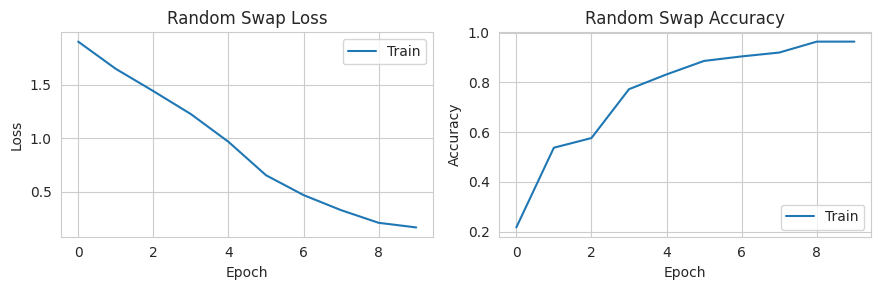

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot training loss values
axes[0].plot(history.history['loss'])
axes[0].set_title('Random Swap Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train'], loc='upper right')

# Plot training accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].set_title('Random Swap Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train'], loc='lower right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Predictions on the test set
predictions = model.predict(X_test_pad)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert encoded labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to compare actual vs. predicted labels
results_df = pd.DataFrame({'Actual_Labels': Y_test, 'Predicted_Labels': predicted_labels})

print("Actual vs. Predicted after Random Swap:")
print(results_df.sample(10))

4/4 [==============================] - 0s 62ms/step
Actual vs. Predicted after Random Swap:
    Actual_Labels Predicted_Labels
338     Analytics          Banking
491       Finance       Consulting
84             IT               IT
445   Engineering      Engineering
538       Finance          Banking
545       Finance          Banking
311    Consulting       Consulting
3              IT               IT
137       Banking          Banking
526       Finance          Banking
